# Les Word Embeddings à partir d’une matrice de co-occurence transformée (approche de Factorisation matricielle)

**Objectif:** L'objectifde ce notebook est d'aborder le problème de dérivation des Word embeddings à partir d’une
matrice de co-occurrencse transformée, afin de mettre en lumières les différents challenges posés
par ce type de données aux méthodes de WE basées sur sur la factorisation matricielle. Pour
l’évaluation des word embeddings, on se focalisera sur les deux tâches largement utilisées dans la
littérature, qui sont la tâche de similarité et la tâche d’analogie.

Réalisé par **Yanis AIT HAMMOU & Sarah YAKOUBENE**

## Importation des bibliothèques

In [14]:
from collections import Counter
from math import sqrt
from random import Random
import os
import numpy as np
import time
from scipy.sparse import csr_matrix, dok_matrix
from sparsesvd import sparsesvd
from scipy.stats.stats import spearmanr
import pandas as pd

## Importation des données
Dans cet exemple, nous formons nos model de word embedding sur un sous ensemble de Wikipedia snapshot anglais disponible via ce lien: https://dumps.wikimedia.org/enwiki/20210501/enwiki-20210501-pages-articles1.xml-p1p41242.bz2

## Extraction des données à partir des article Wikipedia

L'extraction se fait à l'aide du code qui se trouve dans ce lien http://textminingonline.com/training-word2vec-model-on-english-wikipedia-by-gensim

 * Generer le fichier de mots wiki.txt 
```console
user@bar:~$ python extractwiki.py  enwiki-20210220-pages-articles-multistream1.xml-p1p41242.bz2 wiki.txt
```
 * Traitement suplementaire via cette ligne de commande bash
 
 ```console
user@bar:~$ iconv -c -f utf-8 -t ascii  wiki.txt | tr '[A-Z]' '[a-z]' | sed "s/[^a-z0-9]*[ \t\n\r][^a-z0-9]*/ /g" | sed "s/[^a-z0-9]*$/ /g" | sed "s/  */ /g" > cleanwiki.txt
```
Dans le reste de ce notebook, nous utilisons des données déjà nettoyées, qui peuvent être trouvées sur Google Drive : https://drive.google.com/file/d/1z_Qg55AttvOFT9ScACSLY7NO6NpXMANt/view?usp=sharing





## Construction de la matrice de co-occurence

In [2]:
class CorpusPreprocessing():
    """
    
    Extracts a collection of word context from the corpus and Calculates co-occurence matrix
    

    Parameters:
        
        thr : int, default=100,
            The minimal word count for being in the vocabular.
            
        win : int, default=2
            Window size.
            
        pos : Boolean, default=False,
            Positional contexts.
        
        dyn: boolean, default=False,
            Dynamic context windows.
        
        sub : float, default=0,
            Subsampling threshold.
            
        d3l : Boolean, default=False,
            Delete out-of-vocabulary and subsampled placeholders.
            
        return 
    """   
    
    def __init__(self, thr=100, win=2, pos=False, dyn=False, subsample=0, d3l=False):
        self.thr=thr
        self.win=win
        self.pos=pos
        self.dyn=dyn
        self.subsample=subsample
        self.d3l=d3l
        self.sub = subsample != 0
        
    def __read_vocab(self, corpus_file, thr):
        vocab = Counter()
        with open(corpus_file, "r") as f:
            for line in f:
                vocab.update(Counter(line.strip().split()))
        return dict([(token, count) for token, count in list(vocab.items()) if count >= self.thr])
    
    def corpus2pairs(self, corpus_file_input):
        print("Extracts a collection of word context from the corpus ...")
        vocab = self.__read_vocab(corpus_file_input, self.thr)
        corpus_size = sum(vocab.values())
        
        self.subsample *= corpus_size
        subsampler = dict([(word, 1 - sqrt( self.subsample / count)) for word, count in list(vocab.items()) if count >  self.subsample])

        rnd = Random(17)
        pairs = []
        with open(corpus_file, "r") as f: 
            for line in f:

                tokens = [t if t in vocab else None for t in line.strip().split()]
                if self.sub:
                    tokens = [t if t not in subsampler or rnd.random() > subsampler[t] else None for t in tokens]
                if self.d3l:
                    tokens = [t for t in tokens if t is not None]

                len_tokens = len(tokens)

                for i, tok in enumerate(tokens):
                    if tok is not None:
                        if self.dyn:
                            dynamic_window = rnd.randint(1, self.win)
                        else:
                            dynamic_window = self.win
                        start = i - dynamic_window
                        if start < 0:
                            start = 0
                        end = i + dynamic_window + 1
                        if end > len_tokens:
                            end = len_tokens

                        if self.pos:
                            output = '\n'.join([row for row in [tok + ' ' + tokens[j] + '_' + str(j - i) for j in range(start, end) if j != i and tokens[j] is not None] if len(row) > 0]).strip()
                        else:
                            output = '\n'.join([row for row in [tok + ' ' + tokens[j] for j in range(start, end) if j != i and tokens[j] is not None] if len(row) > 0]).strip()
                        if len(output) > 0:
                            pairs.append(output)
        p = []
        for pair in pairs:
            for res in pair.split('\n'):
                p.append(res)
        print("Done")
        return p
                                
    def pairs2counts(self, pairs):
        print("Aggregates identical word-context pairs ...")
        res = np.unique(pairs, return_counts=True)
        print("Done")
        return res
    
    def couts2vocab(self, counts):
        print("Creates vocabularies with the words' and contexts' unigram distributions ...")
        words = Counter()
        contexts = Counter()

        for word_context, count in zip(counts[0], counts[1]):
            word, context = word_context.split()
            words[word] += count
            contexts[context] += count
        words = sorted(list(words.items()), key=lambda x_y: x_y[1], reverse=True)
        contexts = sorted(list(contexts.items()), key=lambda x_y1: x_y1[1], reverse=True)
        print("Done")
        return dict(words), dict(contexts)
    
    
    def counts_matrix(self, counts, words, contexts):
        print("Calculate a Co-occurence matrix from the counts ...")
        words = list(words.keys())
        contexts = list(contexts.keys())
        iw = sorted(words)
        ic = sorted(contexts)
        wi = dict([(w, i) for i, w in enumerate(iw)])
        ci = dict([(c, i) for i, c in enumerate(ic)])

        co_occurence_matrix = csr_matrix((len(wi), len(ci)), dtype=np.float32)
        tmp_counts = dok_matrix((len(wi), len(ci)), dtype=np.float32)
        update_threshold = 100000
        i = 0
        for word_context, count in zip(counts[0], counts[1]):
            word, context = word_context.split()
            if word in wi and context in ci:
                tmp_counts[wi[word], ci[context]] = int(count)
            i += 1
            if i == update_threshold:
                co_occurence_matrix = co_occurence_matrix + tmp_counts.tocsr()
                tmp_counts = dok_matrix((len(wi), len(ci)), dtype=np.float32)
                i = 0
        co_occurence_matrix = co_occurence_matrix + tmp_counts.tocsr()
        print("Done")
        return co_occurence_matrix, iw, ic


    
    def fit(self, corpus_file):
        start = time.time()
        print("Start")
        pairs = self.corpus2pairs(corpus_file)
        print("--->cumulative execution time:", time.time()-start, "s\n")
        counts = self.pairs2counts(pairs)
        print("--->cumulative execution time:", time.time()-start, "s\n")
        words, contexts = self.couts2vocab(counts)
        print("--->cumulative execution time:", time.time()-start, "s\n")
        self.co_occurence_matrix, self.words, self.contexts = self.counts_matrix(counts, words, contexts)
        print("--->cumulative execution time:", time.time()-start, "s\n")
        return self
    
    def fit_transform(self, corpus_file):
        self.fit(corpus_file)
        return self.co_occurence_matrix, self.words, self.contexts

## Transformation de la matrice de co-occurence:
Dans ce notebook nous avons réalisé une comparaison entre ses méthodes: $PMI$, ${PMI}^k$, $PMI$ normalisé, $PPMI$, et la méthode de décomposition factorielle (SVD) avec une variation du nombre de dimension.

$$PMI = log \frac{p(a, b)}{p(a)p(b)}$$
$p(a)$ (resp. $p(b)$) est la probabilité que le mot $a$ (resp. $b$) apparaisse dans une fenêtre de texte d'une taille donnée tandis que $p(a, b)$ désigne la probabilité que $a$ et $b$ co-apparaissent dans la même fenêtre. $PMI$ est donc le $log$ du rapport entre la fréquence de cooccurrence observée et la fréquence attendue en indépendance. Il calcule la mesure dans laquelle les mots apparaissent plus que par hasard ou sont indépendants.

$PMI^k$ consiste à signaler un ou plusieurs facteurs de $p (a, b)$ dans le logarithme pour corriger empiriquement le biais du PMI vers les événements de basse fréquence. Les mesures $PMI^2$ et $PMI^3$ utilisées sont définies comme suit:$$PMI^k(a,b) = PMI(a, b) - (-(k-1)\hspace{1mm}log\hspace{1mm}p(a,b))$$

$NPMI$ ($PMI$ normalisé) est proposé dans (Gerlof, 2006). La motivation principale de cette nouvelle variante est de donner à $PMI$ une borne supérieure fixe de 1 en cas de dépendance parfaite, c'est-à-dire lorsque deux mots n'apparaissent qu'ensemble.Une option pour normaliser PMI est alors de le diviser par $−logp(a, b)$, ce qui donne la définition suivante: $$NMP(a,b) = \frac{PMI(a, b)}{-log\hspace{1mm}p(a, b)}$$

$PPMI$ est une approche plus cohérente consiste à utiliser un $PMI$ positif, dans lequel toutes les valeurs négatives sont remplacées par 0:$$PPMI(a, b) = max(PMI(a, b), 0)$$

$SVD$$$X = U \cdot \Sigma \cdot {V}^{T}$$ où $U$ et $V$ sont orthonormés et $\Sigma$ est une matrice diagonale de valeurs propres par ordre décroissant. En ne conservant que les d éléments supérieurs de $\Sigma$, on obtient $M_{d} = U_{d} \cdot \Sigma_{d} \cdot V^{T}_{d}$.

In [96]:
class PMI:
    
    def __init__(self, co_occurence_matrix, words, contexts, cds=1.0):
        self.wi, self.iw = dict([(a, i) for i, a in enumerate(words)]), words
        self.ci, self.ic = dict([(a, i) for i, a in enumerate(contexts)]), contexts
        self.cds = cds
        self.m = self.__calc_pmi(co_occurence_matrix)
        
        
    def __calc_pmi(self, co_occurence_matrix):
        sum_w = np.array(co_occurence_matrix.sum(axis=1))[:, 0]
        sum_c = np.array(co_occurence_matrix.sum(axis=0))[0, :]
        if self.cds != 1:
            sum_c = sum_c ** self.cds
        sum_total = sum_c.sum()
        sum_w = np.reciprocal(sum_w)
        sum_c = np.reciprocal(sum_c)

        pmi = csr_matrix(co_occurence_matrix)
        pmi = self.__multiply_by_rows(pmi, sum_w)
        pmi = self.__multiply_by_columns(pmi, sum_c)
        pmi = pmi * sum_total
        pmi.data = np.log(pmi.data)
        return pmi
    
    def __multiply_by_rows(self, matrix, row_coefs):
        normalizer = dok_matrix((len(row_coefs), len(row_coefs)))
        normalizer.setdiag(row_coefs)
        return normalizer.tocsr().dot(matrix)


    def __multiply_by_columns(self, matrix, col_coefs):
        normalizer = dok_matrix((len(col_coefs), len(col_coefs)))
        normalizer.setdiag(col_coefs)
        return matrix.dot(normalizer.tocsr())
        
    def normalize(self):
        m2 = self.m.copy()
        m2.data **= 2
        norm = np.reciprocal(np.sqrt(np.array(m2.sum(axis=1))[:, 0]))
        normalizer = dok_matrix((len(norm), len(norm)))
        normalizer.setdiag(norm)
        self.m = normalizer.tocsr().dot(self.m)
        
    def represent(self, w):
        if w in self.wi:
            return self.m[self.wi[w], :]
        else:
            return csr_matrix((1, len(self.ic)))  
        
    def similarity(self, w1, w2):
        return self.represent(w1).dot(self.represent(w2).T)[0, 0]


class PMIP(PMI):
    def __init__(self, co_occurence_matrix, words, contexts, normal=True, p=2,  cds=1.0):
        PMI.__init__(self, co_occurence_matrix=co_occurence_matrix, words=words, contexts=contexts)
        self.m.data = self.m.data ** p
        if normal:
            self.normalize()
        
class NPMI(PMI):
    def __init__(self, co_occurence_matrix, words, contexts, normal=True, cds=1.0):
        PMI.__init__(self, co_occurence_matrix=co_occurence_matrix, words=words, contexts=contexts)
        if normal:
            self.normalize()
    
    
class PPMI(NPMI):
    def __init__(self, co_occurence_matrix, words, contexts, normal=True, cds=1.0):
        NPMI.__init__(self, co_occurence_matrix=co_occurence_matrix, words=words, contexts=contexts, normal=False)
        self.m[self.m < 0] = 0
        self.m.eliminate_zeros()
        if normal:
            self.normalize()
        
class SVDEmbedding(PPMI):
    def __init__(self, co_occurence_matrix, words, contexts, normal=True, eig=0.0, dim=500, cds=1.0):
        PPMI.__init__(self, co_occurence_matrix=co_occurence_matrix, words=words, contexts=contexts, normal=False)
        self.dim = dim
        ut, s, vt = sparsesvd(self.m.tocsc(), dim)
        if eig == 0.0:
            self.m = ut.T
        elif eig == 1.0:
            self.m = s * ut.T
        else:
            self.m = np.power(s, eig) * ut.T
        if normal:
            self.normalize()
            
    def normalize(self):
        norm = np.sqrt(np.sum(self.m * self.m, axis=1))
        self.m = self.m / norm[:, np.newaxis]
            
    def represent(self, w):
        if w in self.wi:
            return self.m[self.wi[w], :]
        else:
            return np.zeros(self.dim)

    def similarity(self, w1, w2):
        return self.represent(w1).dot(self.represent(w2))

## Evaluation :
### Tâche de similarité
Cette tâche d’évaluation est largement utilisée dans la littérature [3]. Supposons que nous disposons d’un jeu de données composé de paires de mots et d’un score de similarité attribué par des humains (score de référence) pour chaque paire. La tâche consiste à comparer les similarités entre les paires de mots à leur score de référence. D’abord, nous calculons la similarité cosinus entre les word embeddings de chaque paire de mots. Puis, nous ordonnons ces
paires par leur degré de similarité. Enfin, nous calculons le coefficient de corrélation Spearman’s rank entre les classements produits par les word embeddings et ceux produits par les scores de référence.


### Tâche d'analogie
La tâche d'analogie proposée par [11] nous permet d'évaluer la similitude relationnelle entre les paires de mots. Cette tâche consiste à répondre à des questions d'analogie basées sur les similitudes cosinus calculées sur les plongements de mots. La relation de similitude entre des paires de mots du même type (par exemple, genre) peut être transformée en une question d'analogie., Lorsqu'on leur donne une paire de mots a et a ∗ et un troisième mot b, la relation d'analogie entre a et a ∗ peut être utilisé pour trouver le mot correspondant b ∗ à b. Mathématiquement, il est exprimé comme :$$a->a^* :: b-> \_\_$$

où le blanc (\_\_) est $b^*$. Un exemple pourrait être
    $$homme->roi^* :: femme->reine^*$$

La méthode 3CosAdd [12] résout pour $b^*$ en utilisant l'équation suivante:
$$b^* = argmax(cos(b', a^* - a + b))$$

Ainsi, une similitude cosinus élevée signifie que les vecteurs partagent une direction similaire. Cependant, il est important de noter que la méthode 3CosAdd normalise les longueurs des vecteurs en utilisant la similarité cosinus [12]. Alternativement, il existe la méthode 3CosMul [13], qui est définie comme :
$$b^* = argmax\frac{cos(b', b)cos(b', a^*)}{cos(b', a^*) +\epsilon}$$
où $\epsilon = 0,001$ est utilisé pour empêcher la division par zéro. La méthode 3CosMul a le même effet en prenant le logarithme de chaque terme avant la sommation. En d'autres termes, les petites différences sont agrandies tandis que les grandes sont supprimées. On voit donc que la méthode 3CosMul offre un meilleur équilibre sous différents aspects.

In [4]:
class Evaluation:
    
    def __init__(self, file_test_name):
        self.file_test_name=file_test_name
        
    
    def read_test_set(self,):
        pass
    
    def evaluate(self, representation):
        pass
    

class Similarity(Evaluation):
    
    def __init__(self, file_test_similarity_name):
        Evaluation.__init__(self, file_test_similarity_name)
        self.data = self.read_test_set()
        
    def read_test_set(self):
        test = []
        with open(self.file_test_name) as f:
            for line in f:
                x, y, sim = line.strip().lower().split()
                test.append(((x, y), sim))
        return test 

    def evaluate(self, representation):
        results = []
        for (x, y), sim in self.data:
            results.append((representation.similarity(x, y), sim))
        actual, expected = list(zip(*results))
        return spearmanr(actual, expected)[0]
    
    
class Analogy(Evaluation):
    
    def __init__(self, file_test_analogy_name):
        Evaluation.__init__(self, file_test_analogy_name)
        self.data = self.read_test_set()
        
    def read_test_set(self):
        test = []
        with open(self.file_test_name) as f:
            for line in f:
                analogy = line.strip().lower().split()
                test.append(analogy)
        return test 
    
    def prepare_similarities(self, representation, vocab):
        vocab_representation = representation.m[[representation.wi[w] if w in representation.wi else 0 for w in vocab]]
        sims = vocab_representation.dot(representation.m.T)

        dummy = None
        for w in vocab:
            if w not in representation.wi:
                dummy = representation.represent(w)
                break
        if dummy is not None:
            for i, w in enumerate(vocab):
                if w not in representation.wi:
                    vocab_representation[i] = dummy

        if type(sims) is not np.ndarray:
            sims = np.array(sims.todense())
        else:
            sims = (sims+1)/2
        return sims

    def guess(self, representation, sims, xi, a, a_, b):
        sa = sims[xi[a]]
        sa_ = sims[xi[a_]]
        sb = sims[xi[b]]

        add_sim = -sa+sa_+sb
        if a in representation.wi:
            add_sim[representation.wi[a]] = 0
        if a_ in representation.wi:
            add_sim[representation.wi[a_]] = 0
        if b in representation.wi:
            add_sim[representation.wi[b]] = 0
        b_add = representation.iw[np.nanargmax(add_sim)]

        mul_sim = sa_*sb*np.reciprocal(sa+0.01)
        if a in representation.wi:
            mul_sim[representation.wi[a]] = 0
        if a_ in representation.wi:
            mul_sim[representation.wi[a_]] = 0
        if b in representation.wi:
            mul_sim[representation.wi[b]] = 0
        b_mul = representation.iw[np.nanargmax(mul_sim)]

        return b_add, b_mul

    def get_vocab(self):
        vocab = set()
        for analogy in self.data:
            vocab.update(analogy)
        vocab = sorted(vocab)
        return dict([(a, i) for i, a in enumerate(vocab)]), vocab

    def evaluate(self, representation):
        xi, ix = self.get_vocab()
        sims = self.prepare_similarities(representation, ix)
        correct_add = 0.0
        correct_mul = 0.0
        for a, a_, b, b_ in self.data:
            b_add, b_mul = self.guess(representation, sims, xi, a, a_, b)
            if b_add == b_:
                correct_add += 1
            if b_mul == b_:
                correct_mul += 1
        return correct_add/len(self.data), correct_mul/len(self.data)

## Effectuer une comparaison de méthodes en utilisant une matrice de cooccurrence calculée avec win_size = 2

In [92]:
corpus_file = "./data/cleanwiki.txt"
corpus_preprocessing = CorpusPreprocessing(win=2, subsample=1e-5)
co_occurence_matrix, words, contexts = corpus_preprocessing.fit_transform(corpus_file)

Start
Extracts a collection of word context from the corpus ...
Done
--->cumulative execution time: 86.63325023651123 s

Aggregates identical word-context pairs ...
Done
--->cumulative execution time: 100.57687330245972 s

Creates vocabularies with the words' and contexts' unigram distributions ...
Done
--->cumulative execution time: 116.38245797157288 s

Calculate a Co-occurence matrix from the counts ...
Done
--->cumulative execution time: 288.83842945098877 s



In [93]:
file_test_analogy_names = ["testsets/analogy/EN-TOM-ICLR13-SEM.txt", "testsets/analogy/EN-TOM-ICLR13-SYN.txt", "testsets/analogy/google.txt", "testsets/analogy/msr.txt"]
filte_test_similarity_names = ["testsets/similarity/bruni_men.txt", "testsets/similarity/luong_rare.txt", "testsets/similarity/radinsky_mturk.txt", "testsets/similarity/ws353.txt", "testsets/similarity/ws353_relatedness.txt", "testsets/similarity/ws353_similarity.txt"]

In [94]:
len(file_test_analogy_names) + len(filte_test_similarity_names)

10

In [99]:
start = time.time()

represenations = {
    "pmi":  PMI(co_occurence_matrix, words, contexts),
    "npmi": NPMI(co_occurence_matrix, words, contexts),
    "pmi_puissance_2": PMIP(co_occurence_matrix, words, contexts, p=2),
    "pmi_puissance_3": PMIP(co_occurence_matrix, words, contexts, p=3),
    "ppmi": PPMI(co_occurence_matrix, words, contexts, normal=True),
    "svd_dim_50":SVDEmbedding(co_occurence_matrix, words, contexts,  normal=True, eig=0.5, dim=50),
    "svd_dim_100":SVDEmbedding(co_occurence_matrix, words, contexts,  normal=True, eig=0.5, dim=100),
    "svd_dim_300":SVDEmbedding(co_occurence_matrix, words, contexts,  normal=True, eig=0.5, dim=300),
    "svd_dim_500":SVDEmbedding(co_occurence_matrix, words, contexts,  normal=True, eig=0.5, dim=500),
    "svd_dim_700":SVDEmbedding(co_occurence_matrix, words, contexts,  normal=True, eig=0.5, dim=700),
    "svd_dim_900":SVDEmbedding(co_occurence_matrix, words, contexts,  normal=True, eig=0.5, dim=900),
}
print("execution time: ", time.time()-start, "s")

execution time:  4186.792149305344 s


In [100]:
start = time.time()

analogy_test_results_add = {}
analogy_test_results_mul = {}
similarity_test_results = {}

print("Assessment with the analogy task :")

for file_test_analogy_name in file_test_analogy_names:
    print("----> evaluation on the file '", file_test_analogy_name, end="' ... ")
    analogy_eval = Analogy(file_test_analogy_name)
    results_add, results_mul = [], []
    for method, representation in represenations.items():
        result_add, result_mul = analogy_eval.evaluate(representation)
        results_add.append(result_add)
        results_mul.append(result_mul)
    analogy_test_results_add[file_test_analogy_name], analogy_test_results_mul[file_test_analogy_name] = results_add, results_mul
    print("Done")

print("Assessment with the analogy task :")
for filte_test_similarity_name in filte_test_similarity_names:
    print("----> evaluation on the file '", filte_test_similarity_name, end="' ... ")
    similarity_eval = Similarity(filte_test_similarity_name)
    results = []
    for method, representation in represenations.items():
        results.append(similarity_eval.evaluate(representation))
    similarity_test_results[filte_test_similarity_name] = results
    print("Done")
    
print("execution time: ", time.time()-start, "s")

Assessment with the analogy task :
----> evaluation on the file ' testsets/analogy/EN-TOM-ICLR13-SEM.txt' ... Done
----> evaluation on the file ' testsets/analogy/EN-TOM-ICLR13-SYN.txt' ... Done
----> evaluation on the file ' testsets/analogy/google.txt' ... Done
----> evaluation on the file ' testsets/analogy/msr.txt' ... Done
Assessment with the analogy task :
----> evaluation on the file ' testsets/similarity/bruni_men.txt' ... Done
----> evaluation on the file ' testsets/similarity/luong_rare.txt' ... Done
----> evaluation on the file ' testsets/similarity/radinsky_mturk.txt' ... Done
----> evaluation on the file ' testsets/similarity/ws353.txt' ... Done
----> evaluation on the file ' testsets/similarity/ws353_relatedness.txt' ... Done
----> evaluation on the file ' testsets/similarity/ws353_similarity.txt' ... Done
execution time:  211.19632053375244 s


In [101]:
analogy_test_results_add

{'testsets/analogy/EN-TOM-ICLR13-SEM.txt': [0.31345134738978464,
  0.3957605141504115,
  0.3877551020408163,
  0.3307024467245462,
  0.394294734468373,
  0.10812943962115233,
  0.14545044537151877,
  0.2655316270154471,
  0.3155936407712256,
  0.31728492501973166,
  0.3105197880257075],
 'testsets/analogy/EN-TOM-ICLR13-SYN.txt': [0.20814988290398126,
  0.28215456674473066,
  0.2332552693208431,
  0.1578454332552693,
  0.2786885245901639,
  0.19456674473067917,
  0.27081967213114755,
  0.30782201405152226,
  0.2785948477751756,
  0.2664168618266979,
  0.262576112412178],
 'testsets/analogy/google.txt': [0.2559353254195661,
  0.3337085550552599,
  0.3033667621776504,
  0.2362873516168645,
  0.33115022513303316,
  0.1553417928776095,
  0.21392754809660253,
  0.28863078182562424,
  0.2953847728203029,
  0.2895006139991813,
  0.2843327875562833],
 'testsets/analogy/msr.txt': [0.180375,
  0.2125,
  0.179875,
  0.143125,
  0.202875,
  0.165875,
  0.216375,
  0.243,
  0.2225,
  0.205375,
  0.2

In [102]:
analogy_test_results_mul

{'testsets/analogy/EN-TOM-ICLR13-SEM.txt': [0.0055248618784530384,
  0.31818694328560154,
  0.39001014770549103,
  0.3683617093246138,
  0.34400721614612695,
  0.09944751381215469,
  0.13902356522719586,
  0.2799639192693652,
  0.33126620814071484,
  0.34231593189762094,
  0.3413011613485173],
 'testsets/analogy/EN-TOM-ICLR13-SYN.txt': [0.021639344262295083,
  0.2973302107728337,
  0.2613583138173302,
  0.19812646370023418,
  0.29779859484777516,
  0.15550351288056205,
  0.25142857142857145,
  0.3307728337236534,
  0.30313817330210774,
  0.29292740046838406,
  0.2845901639344262],
 'testsets/analogy/google.txt': [0.014326647564469915,
  0.3067949242734343,
  0.31974007367990176,
  0.27537863282848957,
  0.31876790830945556,
  0.130065493246009,
  0.20041956610724518,
  0.30771592304543594,
  0.3159025787965616,
  0.3153397462136717,
  0.31032541956610726],
 'testsets/analogy/msr.txt': [0.013625,
  0.213375,
  0.18825,
  0.133875,
  0.215125,
  0.140375,
  0.20775,
  0.2575,
  0.230125,

In [103]:
similarity_test_results

{'testsets/similarity/bruni_men.txt': [-0.016398390452288802,
  0.15737331738418942,
  0.174586990415354,
  0.18007026731319975,
  0.1569586477400256,
  0.11808721561412062,
  0.14210960373695278,
  0.1845104442876597,
  0.20306678075773008,
  0.2097584086761614,
  0.20294644922313293],
 'testsets/similarity/luong_rare.txt': [-0.06862989761923448,
  -0.04910857747910807,
  -0.046301663859325465,
  -0.04631081371016524,
  -0.04924469338869075,
  -0.0004069009815587779,
  0.010822260400228639,
  0.038861863011822935,
  0.03974700581816493,
  0.0596512879027325,
  0.061221785356910016],
 'testsets/similarity/radinsky_mturk.txt': [0.08472324068856567,
  0.5764006780481467,
  0.5829292240121793,
  0.5898486704732807,
  0.5764080073724205,
  0.6078539534986576,
  0.6274535521227937,
  0.5834323180285367,
  0.5878969601343442,
  0.5638740939375319,
  0.5563319988275278],
 'testsets/similarity/ws353.txt': [-0.05870948351739003,
  0.4938654390854075,
  0.5451724296243665,
  0.5484763710219082,


In [104]:
similarity_results_df = pd.DataFrame.from_dict(similarity_test_results)
similarity_results_df.index = list(represenations.keys())
similarity_results_df

,testsets/similarity/bruni_men.txt,testsets/similarity/luong_rare.txt,testsets/similarity/radinsky_mturk.txt,testsets/similarity/ws353.txt,testsets/similarity/ws353_relatedness.txt,testsets/similarity/ws353_similarity.txt
pmi,-0.016398,-0.068630,0.084723,-0.058709,0.107822,-0.146641
npmi,0.157373,-0.049109,0.576401,0.493865,0.521776,0.523679
pmi_puissance_2,0.174587,-0.046302,0.582929,0.545172,0.579157,0.563667
pmi_puissance_3,0.180070,-0.046311,0.589849,0.548476,0.577944,0.567303
ppmi,0.156959,-0.049245,0.576408,0.493514,0.520975,0.523402
svd_dim_50,0.118087,-0.000407,0.607854,0.526677,0.515645,0.568689
svd_dim_100,0.142110,0.010822,0.627454,0.576275,0.579867,0.585774
svd_dim_300,0.184510,0.038862,0.583432,0.609607,0.629942,0.623346
svd_dim_500,0.203067,0.039747,0.587897,0.621062,0.636757,0.621306
svd_dim_700,0.209758,0.059651,0.563874,0.622480,0.634848,0.634425


In [105]:
analogy_add_results_df = pd.DataFrame.from_dict(analogy_test_results_add)
analogy_add_results_df.index = list(represenations.keys())
analogy_add_results_df

,testsets/analogy/EN-TOM-ICLR13-SEM.txt,testsets/analogy/EN-TOM-ICLR13-SYN.txt,testsets/analogy/google.txt,testsets/analogy/msr.txt
pmi,0.313451,0.208150,0.255935,0.180375
npmi,0.395761,0.282155,0.333709,0.212500
pmi_puissance_2,0.387755,0.233255,0.303367,0.179875
pmi_puissance_3,0.330702,0.157845,0.236287,0.143125
ppmi,0.394295,0.278689,0.331150,0.202875
svd_dim_50,0.108129,0.194567,0.155342,0.165875
svd_dim_100,0.145450,0.270820,0.213928,0.216375
svd_dim_300,0.265532,0.307822,0.288631,0.243000
svd_dim_500,0.315594,0.278595,0.295385,0.222500
svd_dim_700,0.317285,0.266417,0.289501,0.205375


In [106]:
analogy_mul_results_df = pd.DataFrame.from_dict(analogy_test_results_mul)
analogy_mul_results_df.index = list(represenations.keys())
analogy_mul_results_df

,testsets/analogy/EN-TOM-ICLR13-SEM.txt,testsets/analogy/EN-TOM-ICLR13-SYN.txt,testsets/analogy/google.txt,testsets/analogy/msr.txt
pmi,0.005525,0.021639,0.014327,0.013625
npmi,0.318187,0.297330,0.306795,0.213375
pmi_puissance_2,0.390010,0.261358,0.319740,0.188250
pmi_puissance_3,0.368362,0.198126,0.275379,0.133875
ppmi,0.344007,0.297799,0.318768,0.215125
svd_dim_50,0.099448,0.155504,0.130065,0.140375
svd_dim_100,0.139024,0.251429,0.200420,0.207750
svd_dim_300,0.279964,0.330773,0.307716,0.257500
svd_dim_500,0.331266,0.303138,0.315903,0.230125
svd_dim_700,0.342316,0.292927,0.315340,0.211625


<AxesSubplot:>

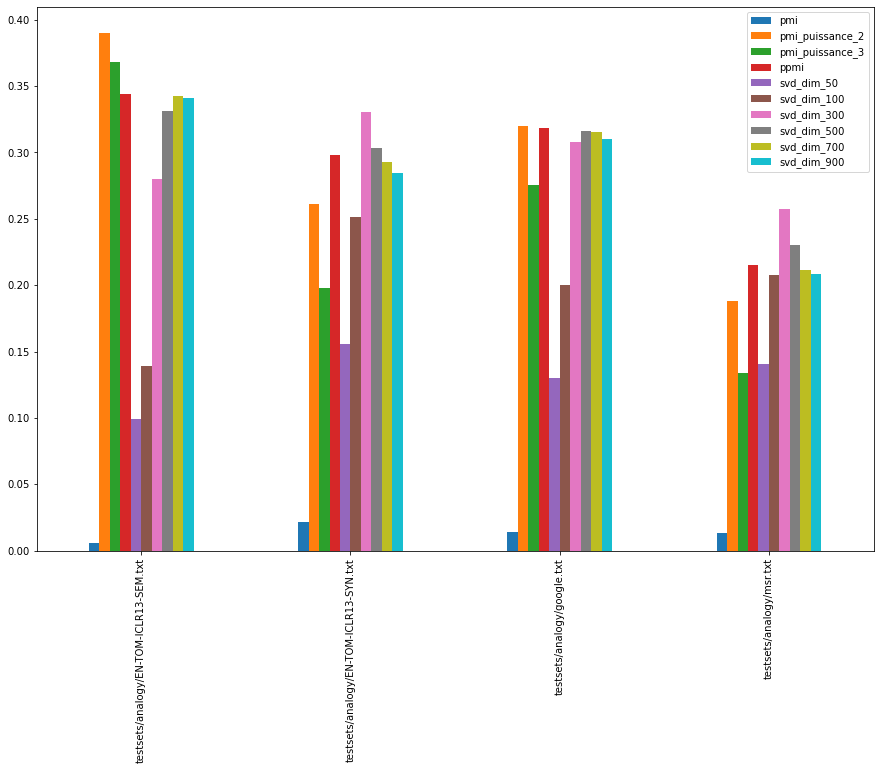

In [55]:
analogy_mul_results_df.T.plot.bar(figsize=(15, 10))

<AxesSubplot:>

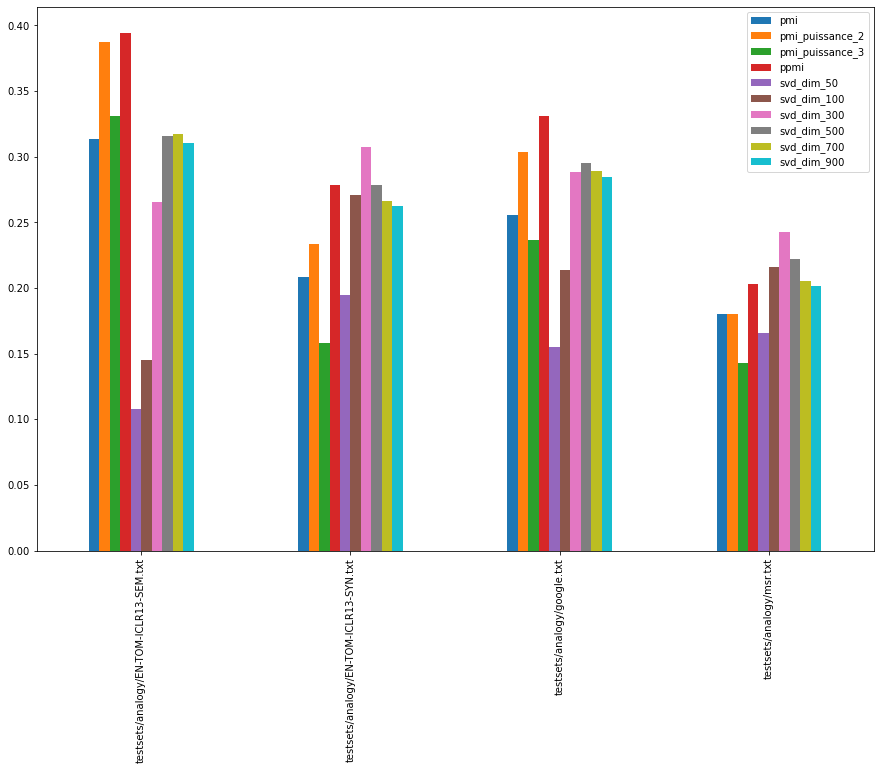

In [56]:
analogy_add_results_df.T.plot.bar(figsize=(15, 10))

<AxesSubplot:>

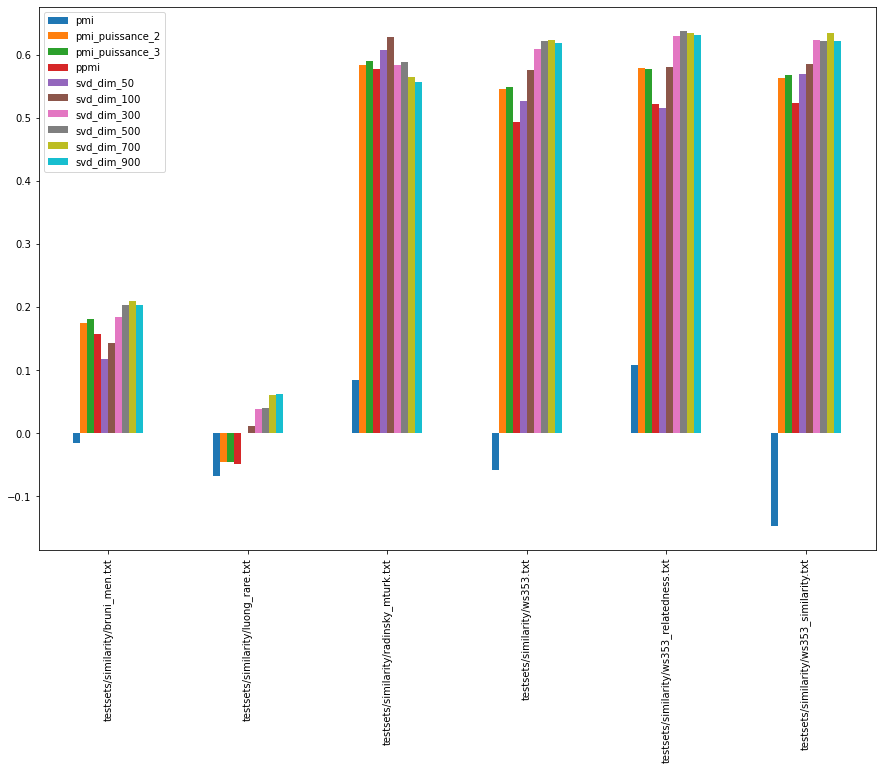

In [57]:
similarity_results_df.T.plot.bar(figsize=(15, 10))

## Effectuer une comparaison de méthodes en utilisant une matrice de co-occurrence calculée avec win_size = 5

In [82]:
corpus_file = "./data/cleanwiki.txt"
corpus_preprocessing = CorpusPreprocessing(win=5, subsample=1e-5)
co_occurence_matrix, words, contexts = corpus_preprocessing.fit_transform(corpus_file)

Start
Extracts a collection of word context from the corpus ...
Done
--->cumulative execution time: 108.32113361358643 s

Aggregates identical word-context pairs ...
Done
--->cumulative execution time: 147.91133975982666 s

Creates vocabularies with the words' and contexts' unigram distributions ...
Done
--->cumulative execution time: 188.71994924545288 s

Calculate a Co-occurence matrix from the counts ...
Done
--->cumulative execution time: 616.3386013507843 s



In [83]:
start = time.time()

represenations = {
    "pmi":  PMI(co_occurence_matrix, words, contexts),
    "pmi_puissance_2": PMIP(co_occurence_matrix, words, contexts, p=2),
    "pmi_puissance_3": PMIP(co_occurence_matrix, words, contexts, p=3),
    "ppmi": PPMI(co_occurence_matrix, words, contexts, normal=True),
    "svd_dim_50":SVDEmbedding(co_occurence_matrix, words, contexts,  normal=True, eig=0.5, dim=50),
    "svd_dim_100":SVDEmbedding(co_occurence_matrix, words, contexts,  normal=True, eig=0.5, dim=100),
    "svd_dim_300":SVDEmbedding(co_occurence_matrix, words, contexts,  normal=True, eig=0.5, dim=300),
    "svd_dim_500":SVDEmbedding(co_occurence_matrix, words, contexts,  normal=True, eig=0.5, dim=500),
    "svd_dim_700":SVDEmbedding(co_occurence_matrix, words, contexts,  normal=True, eig=0.5, dim=700),
    "svd_dim_900":SVDEmbedding(co_occurence_matrix, words, contexts,  normal=True, eig=0.5, dim=900),
}
print("execution time: ", time.time()-start, "s")

execution time:  5213.623113393784 s


In [84]:
start = time.time()

analogy_test_results_add = {}
analogy_test_results_mul = {}
similarity_test_results = {}

print("Assessment with the analogy task :")

for file_test_analogy_name in file_test_analogy_names:
    print("----> evaluation on the file '", file_test_analogy_name, end="' ... ")
    analogy_eval = Analogy(file_test_analogy_name)
    results_add, results_mul = [], []
    for method, representation in represenations.items():
        result_add, result_mul = analogy_eval.evaluate(representation)
        results_add.append(result_add)
        results_mul.append(result_mul)
    analogy_test_results_add[file_test_analogy_name], analogy_test_results_mul[file_test_analogy_name] = results_add, results_mul
    print("Done")

print("Assessment with the analogy task :")
for filte_test_similarity_name in filte_test_similarity_names:
    print("----> evaluation on the file '", filte_test_similarity_name, end="' ... ")
    similarity_eval = Similarity(filte_test_similarity_name)
    results = []
    for method, representation in represenations.items():
        results.append(similarity_eval.evaluate(representation))
    similarity_test_results[filte_test_similarity_name] = results
    print("Done")
    
print("execution time: ", time.time()-start, "s")

Assessment with the analogy task :
----> evaluation on the file ' testsets/analogy/EN-TOM-ICLR13-SEM.txt' ... Done
----> evaluation on the file ' testsets/analogy/EN-TOM-ICLR13-SYN.txt' ... Done
----> evaluation on the file ' testsets/analogy/google.txt' ... Done
----> evaluation on the file ' testsets/analogy/msr.txt' ... Done
Assessment with the analogy task :
----> evaluation on the file ' testsets/similarity/bruni_men.txt' ... Done
----> evaluation on the file ' testsets/similarity/luong_rare.txt' ... Done
----> evaluation on the file ' testsets/similarity/radinsky_mturk.txt' ... Done
----> evaluation on the file ' testsets/similarity/ws353.txt' ... Done
----> evaluation on the file ' testsets/similarity/ws353_relatedness.txt' ... Done
----> evaluation on the file ' testsets/similarity/ws353_similarity.txt' ... Done
execution time:  318.39519476890564 s


In [85]:
similarity_results_df = pd.DataFrame.from_dict(similarity_test_results)
similarity_results_df.index = list(represenations.keys())
similarity_results_df

,testsets/similarity/bruni_men.txt,testsets/similarity/luong_rare.txt,testsets/similarity/radinsky_mturk.txt,testsets/similarity/ws353.txt,testsets/similarity/ws353_relatedness.txt,testsets/similarity/ws353_similarity.txt
pmi,-0.039274,-0.071802,-0.205700,-0.090358,-0.138911,-0.159659
pmi_puissance_2,0.171607,-0.047953,0.602428,0.556929,0.611007,0.563220
pmi_puissance_3,0.181601,-0.045050,0.603214,0.579679,0.629737,0.588660
ppmi,0.149423,-0.053150,0.577099,0.474579,0.525221,0.488373
svd_dim_50,0.126985,-0.009079,0.608327,0.520717,0.499081,0.560794
svd_dim_100,0.148577,-0.003790,0.606844,0.569792,0.570312,0.574095
svd_dim_300,0.175204,0.010428,0.604848,0.608517,0.621670,0.628597
svd_dim_500,0.195598,0.024124,0.609974,0.619923,0.639867,0.637618
svd_dim_700,0.207171,0.012887,0.627300,0.619639,0.632602,0.647979
svd_dim_900,0.206706,0.017550,0.607842,0.621711,0.635945,0.642823


In [86]:
analogy_add_results_df = pd.DataFrame.from_dict(analogy_test_results_add)
analogy_add_results_df.index = list(represenations.keys())
analogy_add_results_df

,testsets/analogy/EN-TOM-ICLR13-SEM.txt,testsets/analogy/EN-TOM-ICLR13-SYN.txt,testsets/analogy/google.txt,testsets/analogy/msr.txt
pmi,0.451798,0.215457,0.322708,0.171625
pmi_puissance_2,0.441200,0.226417,0.323885,0.141875
pmi_puissance_3,0.407148,0.177049,0.281467,0.121875
ppmi,0.451911,0.243091,0.337853,0.148750
svd_dim_50,0.128087,0.200937,0.167878,0.146625
svd_dim_100,0.180629,0.293864,0.242479,0.200750
svd_dim_300,0.326531,0.354567,0.341844,0.240625
svd_dim_500,0.389559,0.339485,0.362208,0.218375
svd_dim_700,0.410418,0.317939,0.359906,0.201750
svd_dim_900,0.416394,0.302763,0.354329,0.196000


In [87]:
analogy_mul_results_df = pd.DataFrame.from_dict(analogy_test_results_mul)
analogy_mul_results_df.index = list(represenations.keys())
analogy_mul_results_df

,testsets/analogy/EN-TOM-ICLR13-SEM.txt,testsets/analogy/EN-TOM-ICLR13-SYN.txt,testsets/analogy/google.txt,testsets/analogy/msr.txt
pmi,0.168001,0.189977,0.180004,0.120000
pmi_puissance_2,0.425189,0.254895,0.332174,0.146000
pmi_puissance_3,0.416281,0.212272,0.304851,0.110500
ppmi,0.411208,0.266698,0.332276,0.153000
svd_dim_50,0.115571,0.158314,0.138917,0.117750
svd_dim_100,0.164393,0.267354,0.220630,0.191125
svd_dim_300,0.326869,0.367681,0.349161,0.256750
svd_dim_500,0.393280,0.357283,0.373619,0.227375
svd_dim_700,0.417860,0.340796,0.375767,0.210875
svd_dim_900,0.425527,0.322436,0.369218,0.203875


<AxesSubplot:>

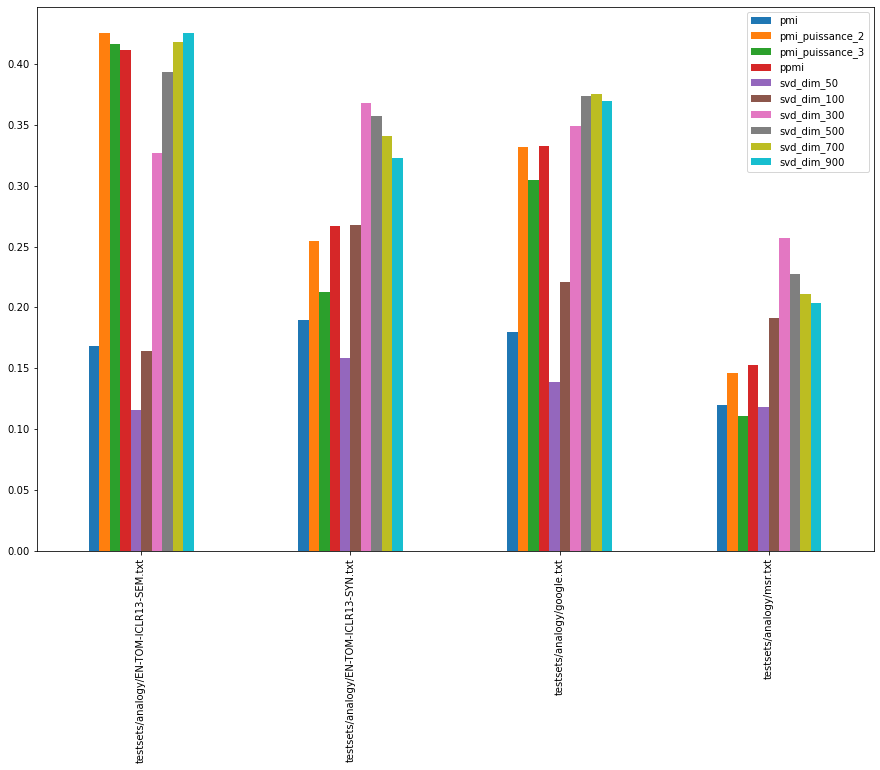

In [89]:
analogy_mul_results_df.T.plot.bar(figsize=(15, 10))

<AxesSubplot:>

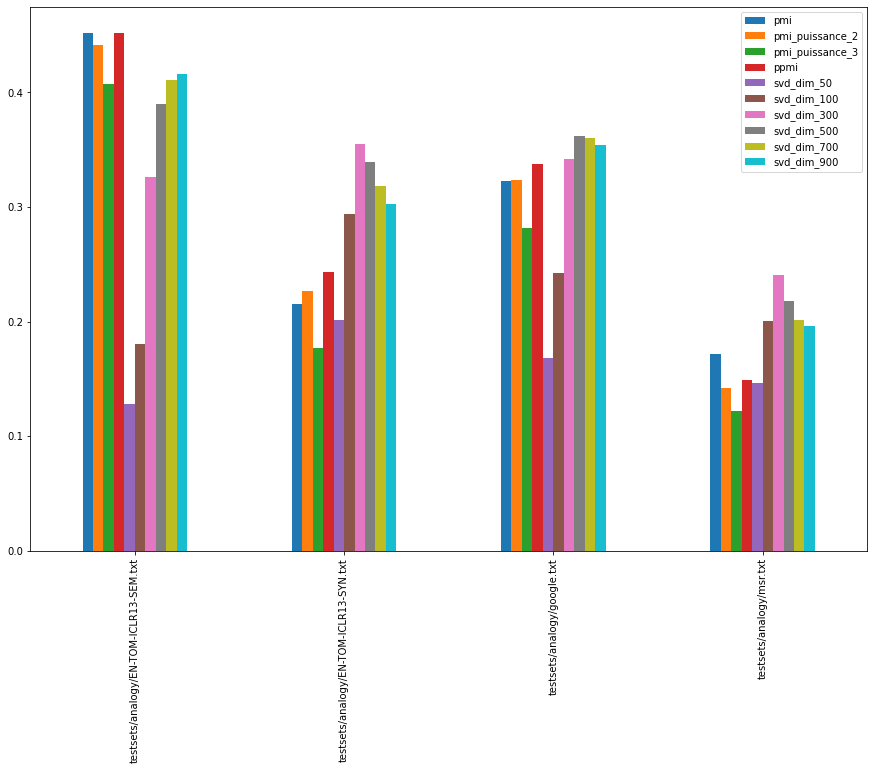

In [90]:
analogy_add_results_df.T.plot.bar(figsize=(15, 10))

<AxesSubplot:>

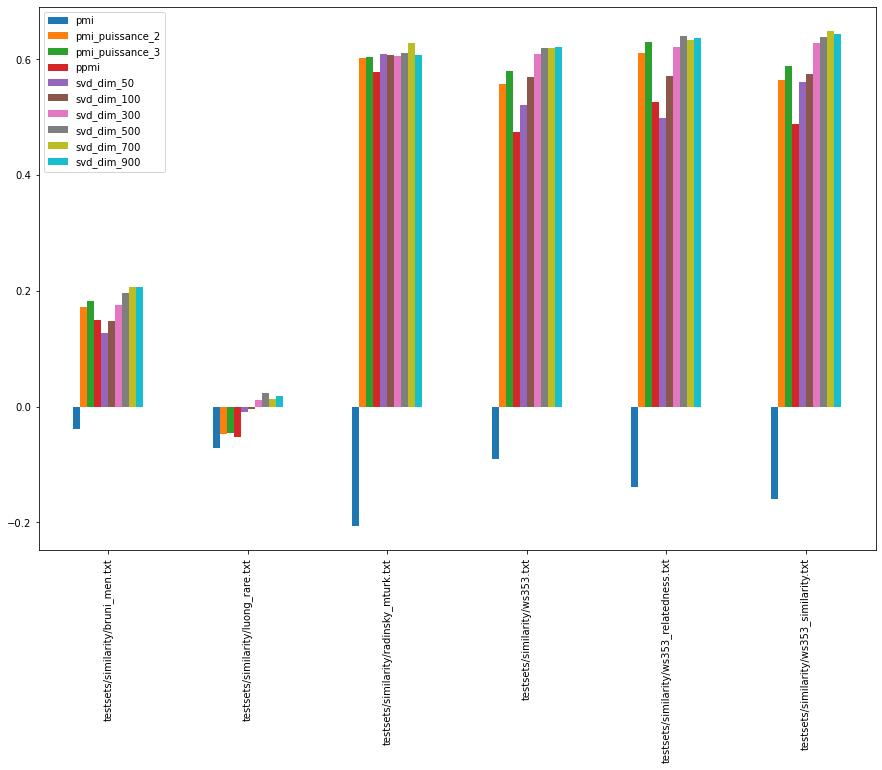

In [91]:
similarity_results_df.T.plot.bar(figsize=(15, 10))